In [93]:
import matplotlib.pyplot as plt
import pandas as pd
# import rdkit components
from rdkit import rdBase
from rdkit import Chem
from rdkit.Chem import AllChem, MolToSmiles
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors
import os
import matplotlib.pyplot as plt

# Functions of Interest:


In [87]:
def check_substructure(mol_list, substructure_SMARTS):
	"""
	Check whether a SMARTS pattern of a substructure is present in a set of molecules and identify where the substructure is present and where it is not present.
	:param mol_list: A list of SMILES
	:param substructure_SMARTS: SMARTS pattern for recognizing a specific substructure
	:return: selected_mol_list: A list of SMILES of molecules containing the substructure.
	"""
	molecule_list = [Chem.MolFromSmiles(x) for x in mol_list]
	sub_structure = Chem.MolFromSmarts(substructure_SMARTS)
	selected_molecules_list = []
	unselected_molecules_list = []
	for molecule in molecule_list:
		if molecule.HasSubstructMatch(sub_structure):
			selected_molecules_list.append(Chem.MolToSmiles(molecule))
		else:
			unselected_molecules_list.append(Chem.MolToSmiles(molecule))
	return selected_molecules_list, unselected_molecules_list

## Substructure Searches 
I want to check whether the SMARTS pattern that I am using will work with the structures in a reaction component.

In [4]:
# First lets start by loading the building blocks and converting them to molecules in a list
reagent_list_1 = []
with open('./Data/M_pro/aldehydes.smi') as f:
	for line in f.readlines():
		reagent_list_1.append(Chem.MolFromSmiles(line))

In [5]:
sub_struc = Chem.MolFromSmarts('[CX3H1](=O)[#6:3]')
for mol in reagent_list_1:
	print(mol.HasSubstructMatch(sub_struc))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


# SARS-CoV-2 $M_{Pro}$ Library

## Amino Acid Coupling

First check whether there are any FMOC groups present with the amino acids

In [3]:
amino_acids_no_FMOC = []
fmoc_substructure = Chem.MolFromSmarts('[c]1[c][c]c2c([c]1)-c3[c][c][c][c]c3[C]2[C]O[C]=O')
with open('./Data/M_pro/amino_acids.smi') as f:
	for mol in f:
		molecule = Chem.MolFromSmiles(mol)
		if not molecule.HasSubstructMatch(fmoc_substructure):
			amino_acids_no_FMOC.append(mol)
		

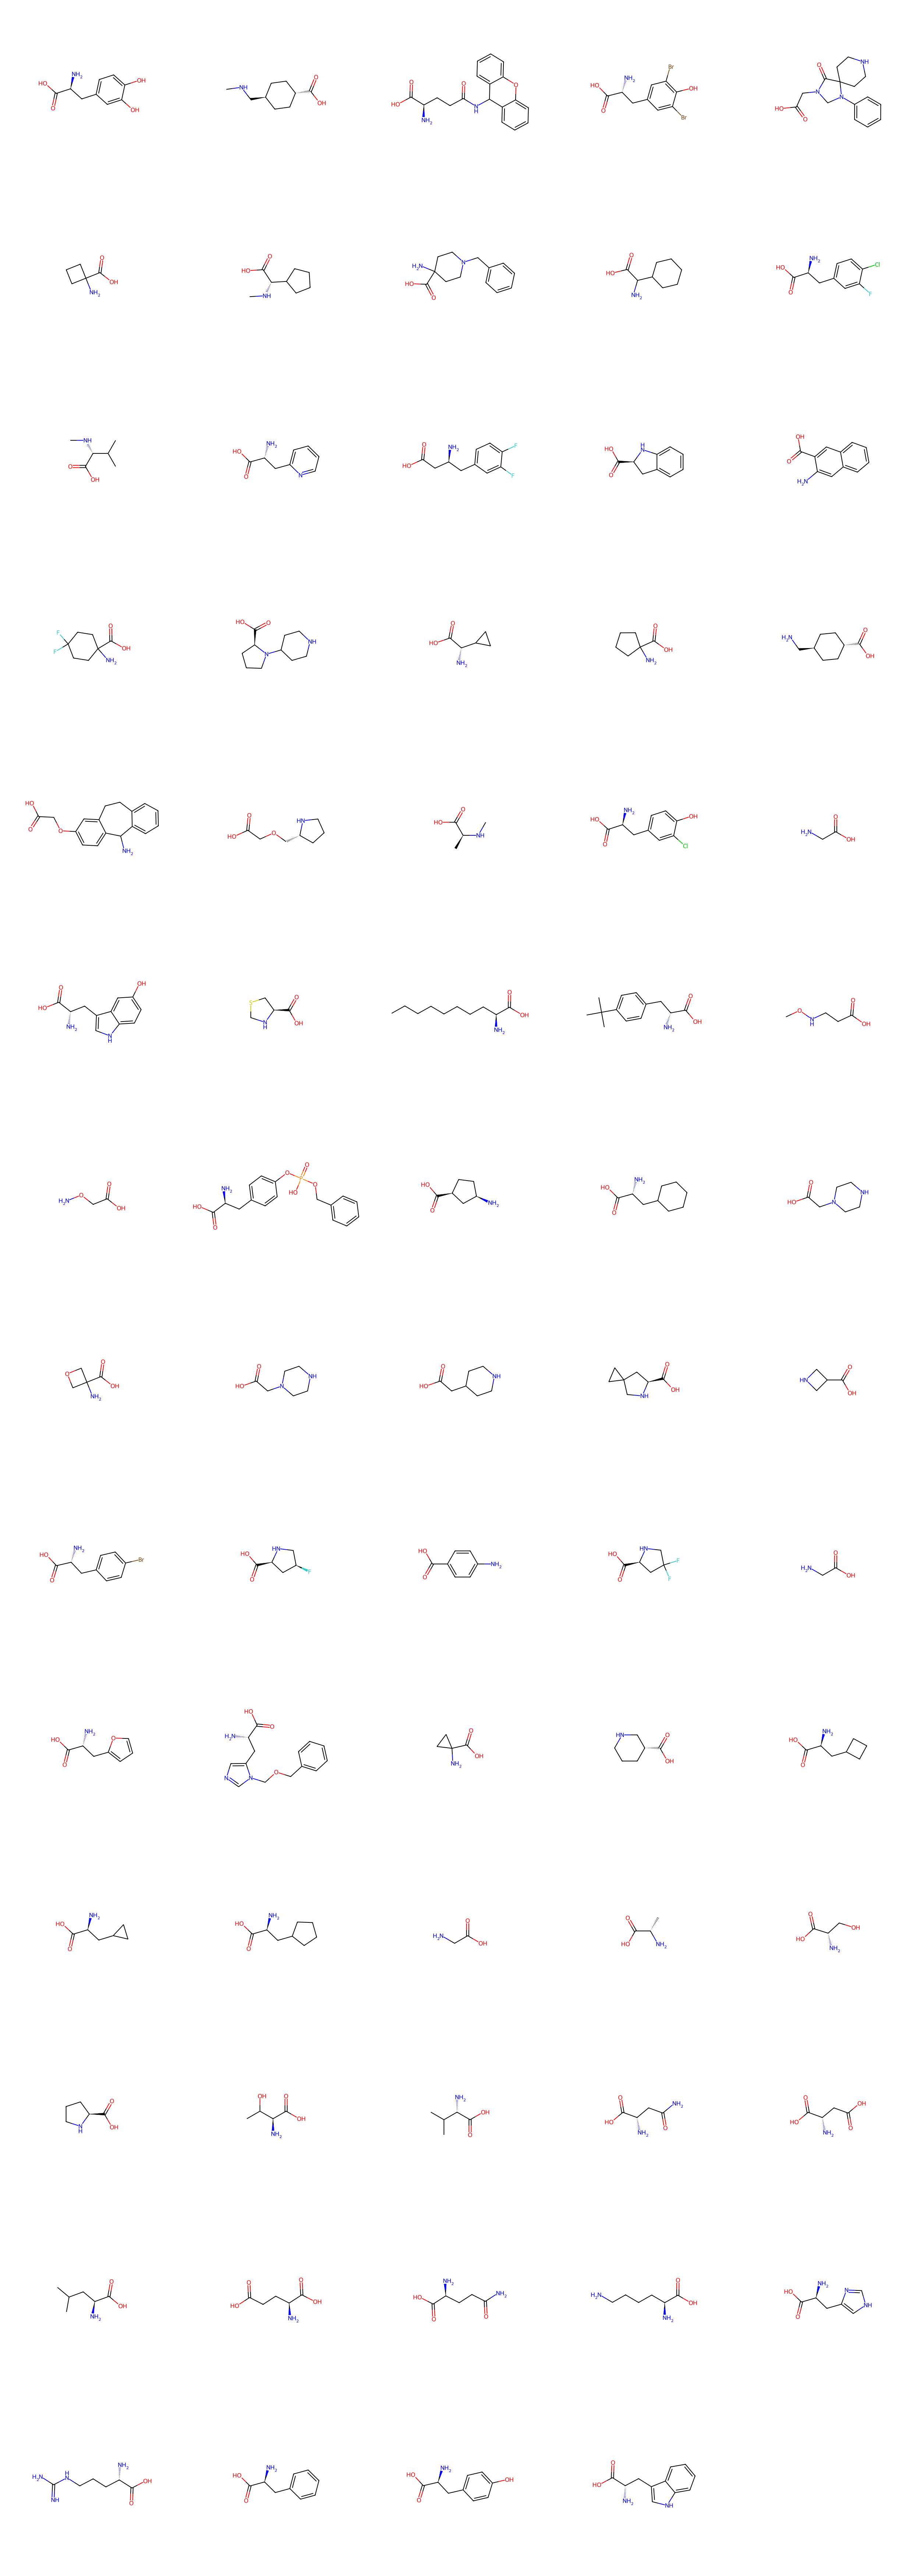

In [4]:
# Visualize all the amino acid structures
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in amino_acids_no_FMOC],molsPerRow=5, subImgSize=(500, 500),maxMols=70)

### Amino acids Library members
Please take note that there are certain members with 3 ringed structures present which may look similar to Fmoc but are not Fmoc (See structure no. 25). 

### Primary Amine Amino Acids Library Members
We need to find amino acids with terminal primary amines since these will be coupling site for the aldehyde. Lets screen the amino acids for those members with terminal primary amines.

In [17]:
primary_amines=[]
primary_amine_SMARTS = Chem.MolFromSmarts("[#7X3;H2]")
i=0
with open('./Data/M_pro/amino_acids.smi') as f:
	for mol in f:
		i+=1
		molecule = Chem.MolFromSmiles(mol)
		if molecule.HasSubstructMatch(primary_amine_SMARTS):
			primary_amines.append(mol)

In [88]:
primary_amines, no_primary_amines = check_substructure(amino_acids_no_FMOC,"[#7X3;H2]")

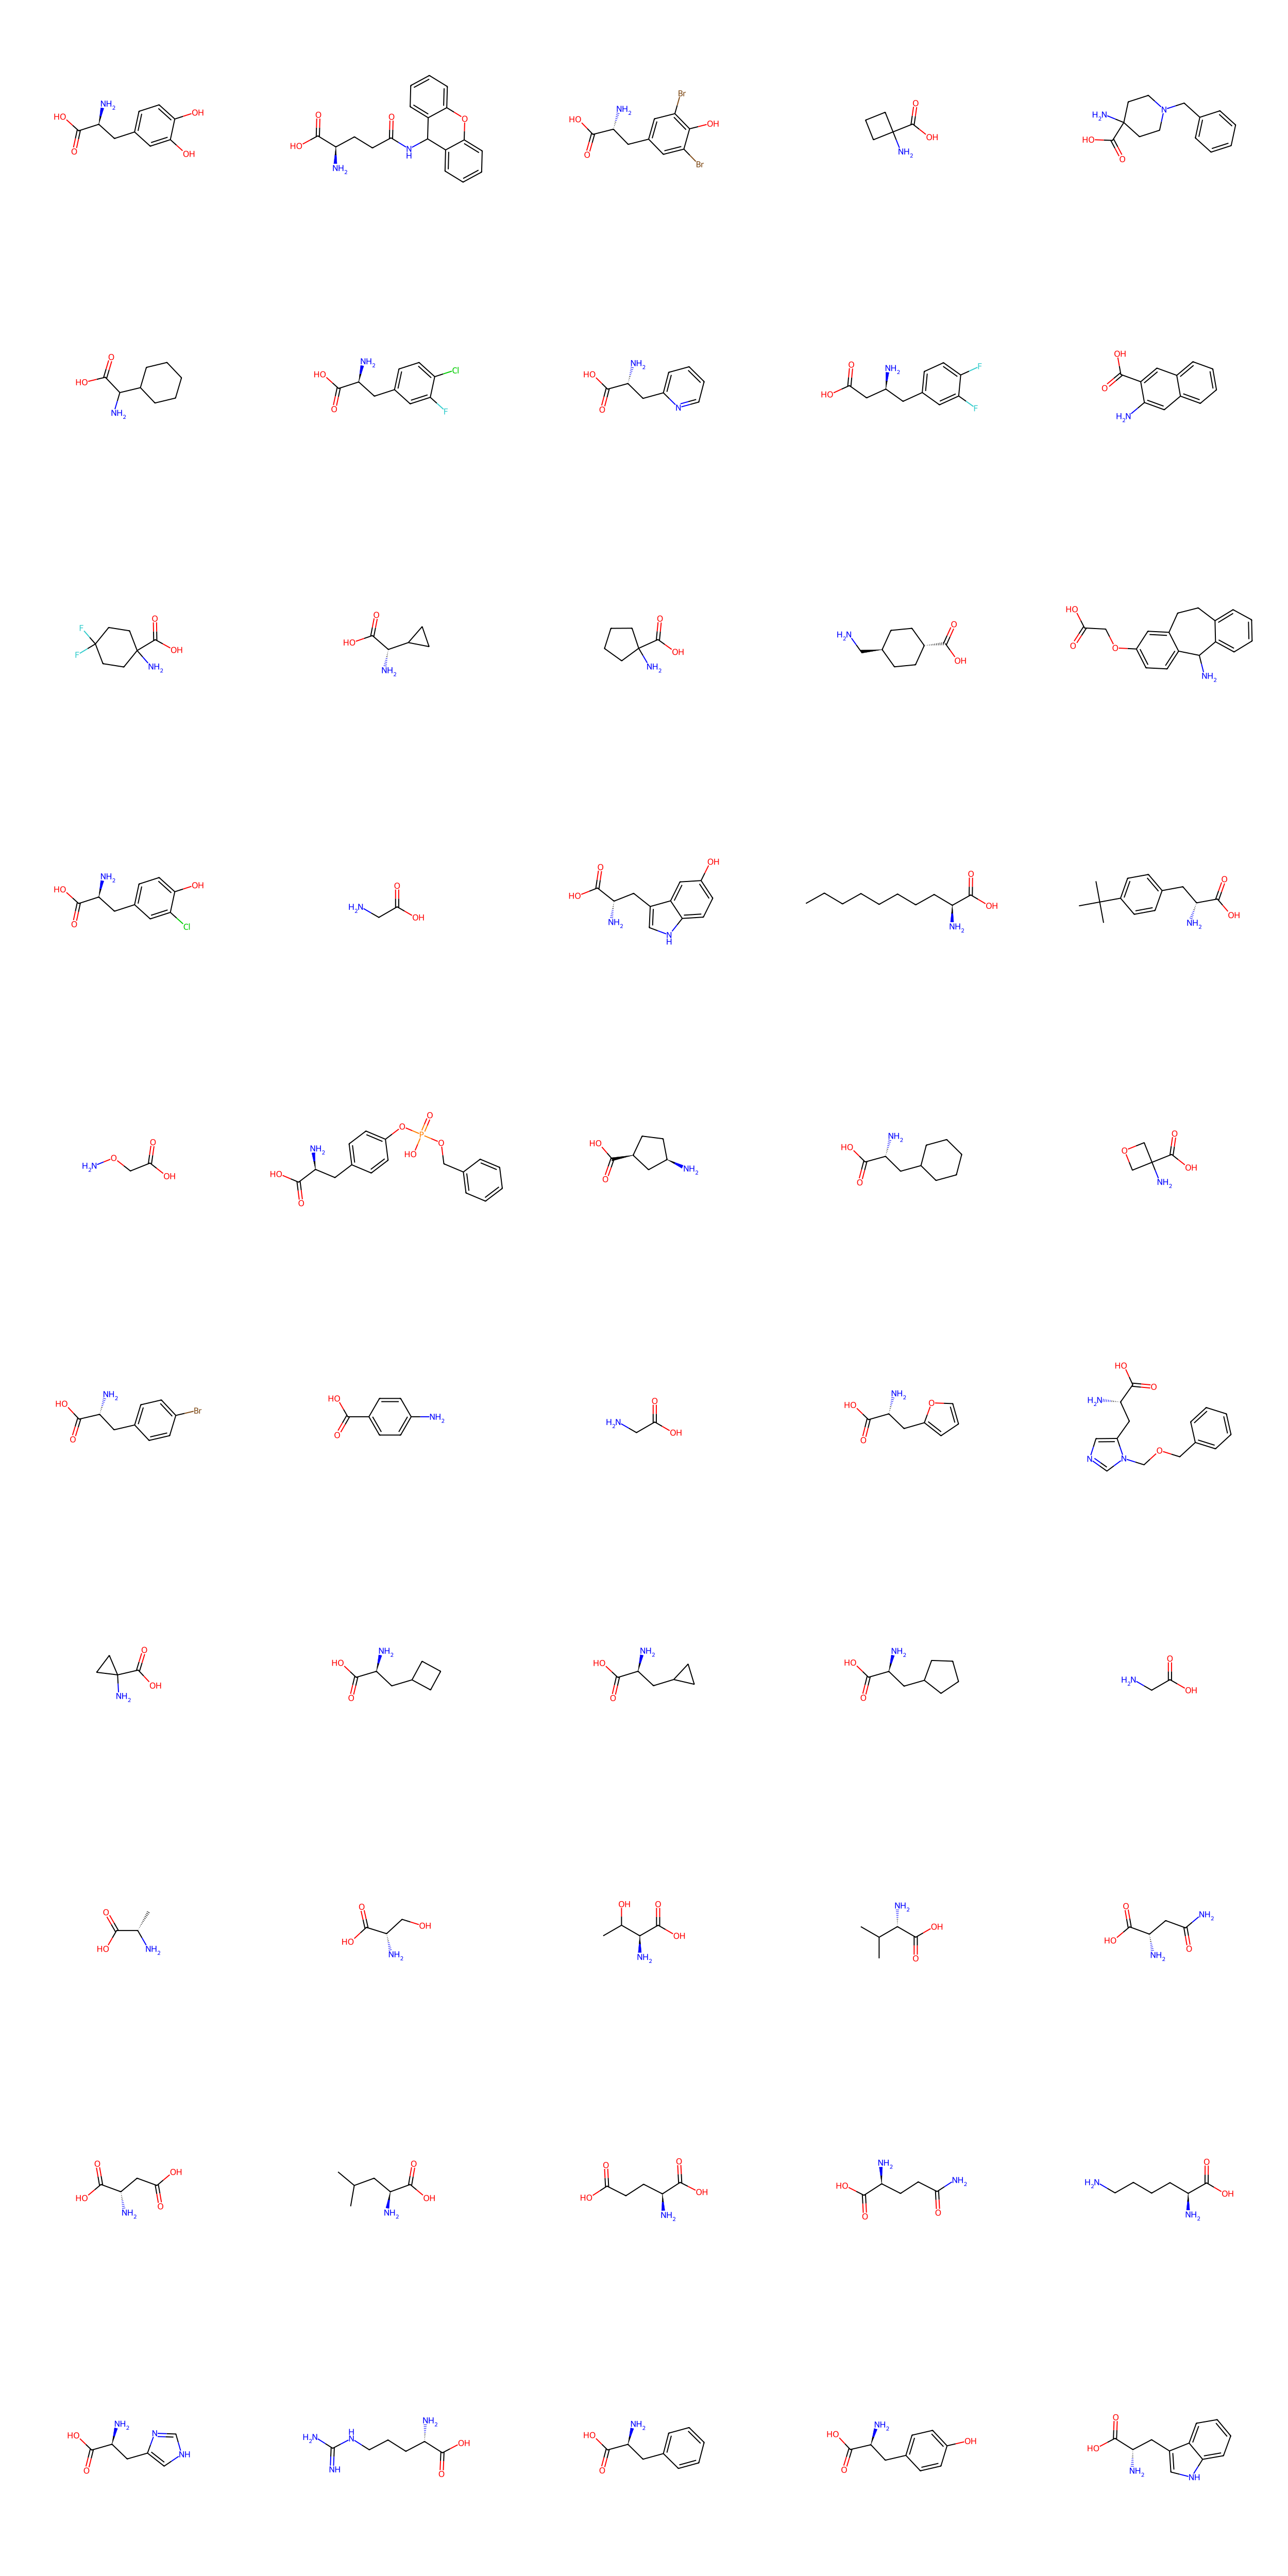

In [89]:
# Visualize Amino Acids with a primary amine
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in primary_amines],molsPerRow=5, subImgSize=(500, 500),maxMols=70)

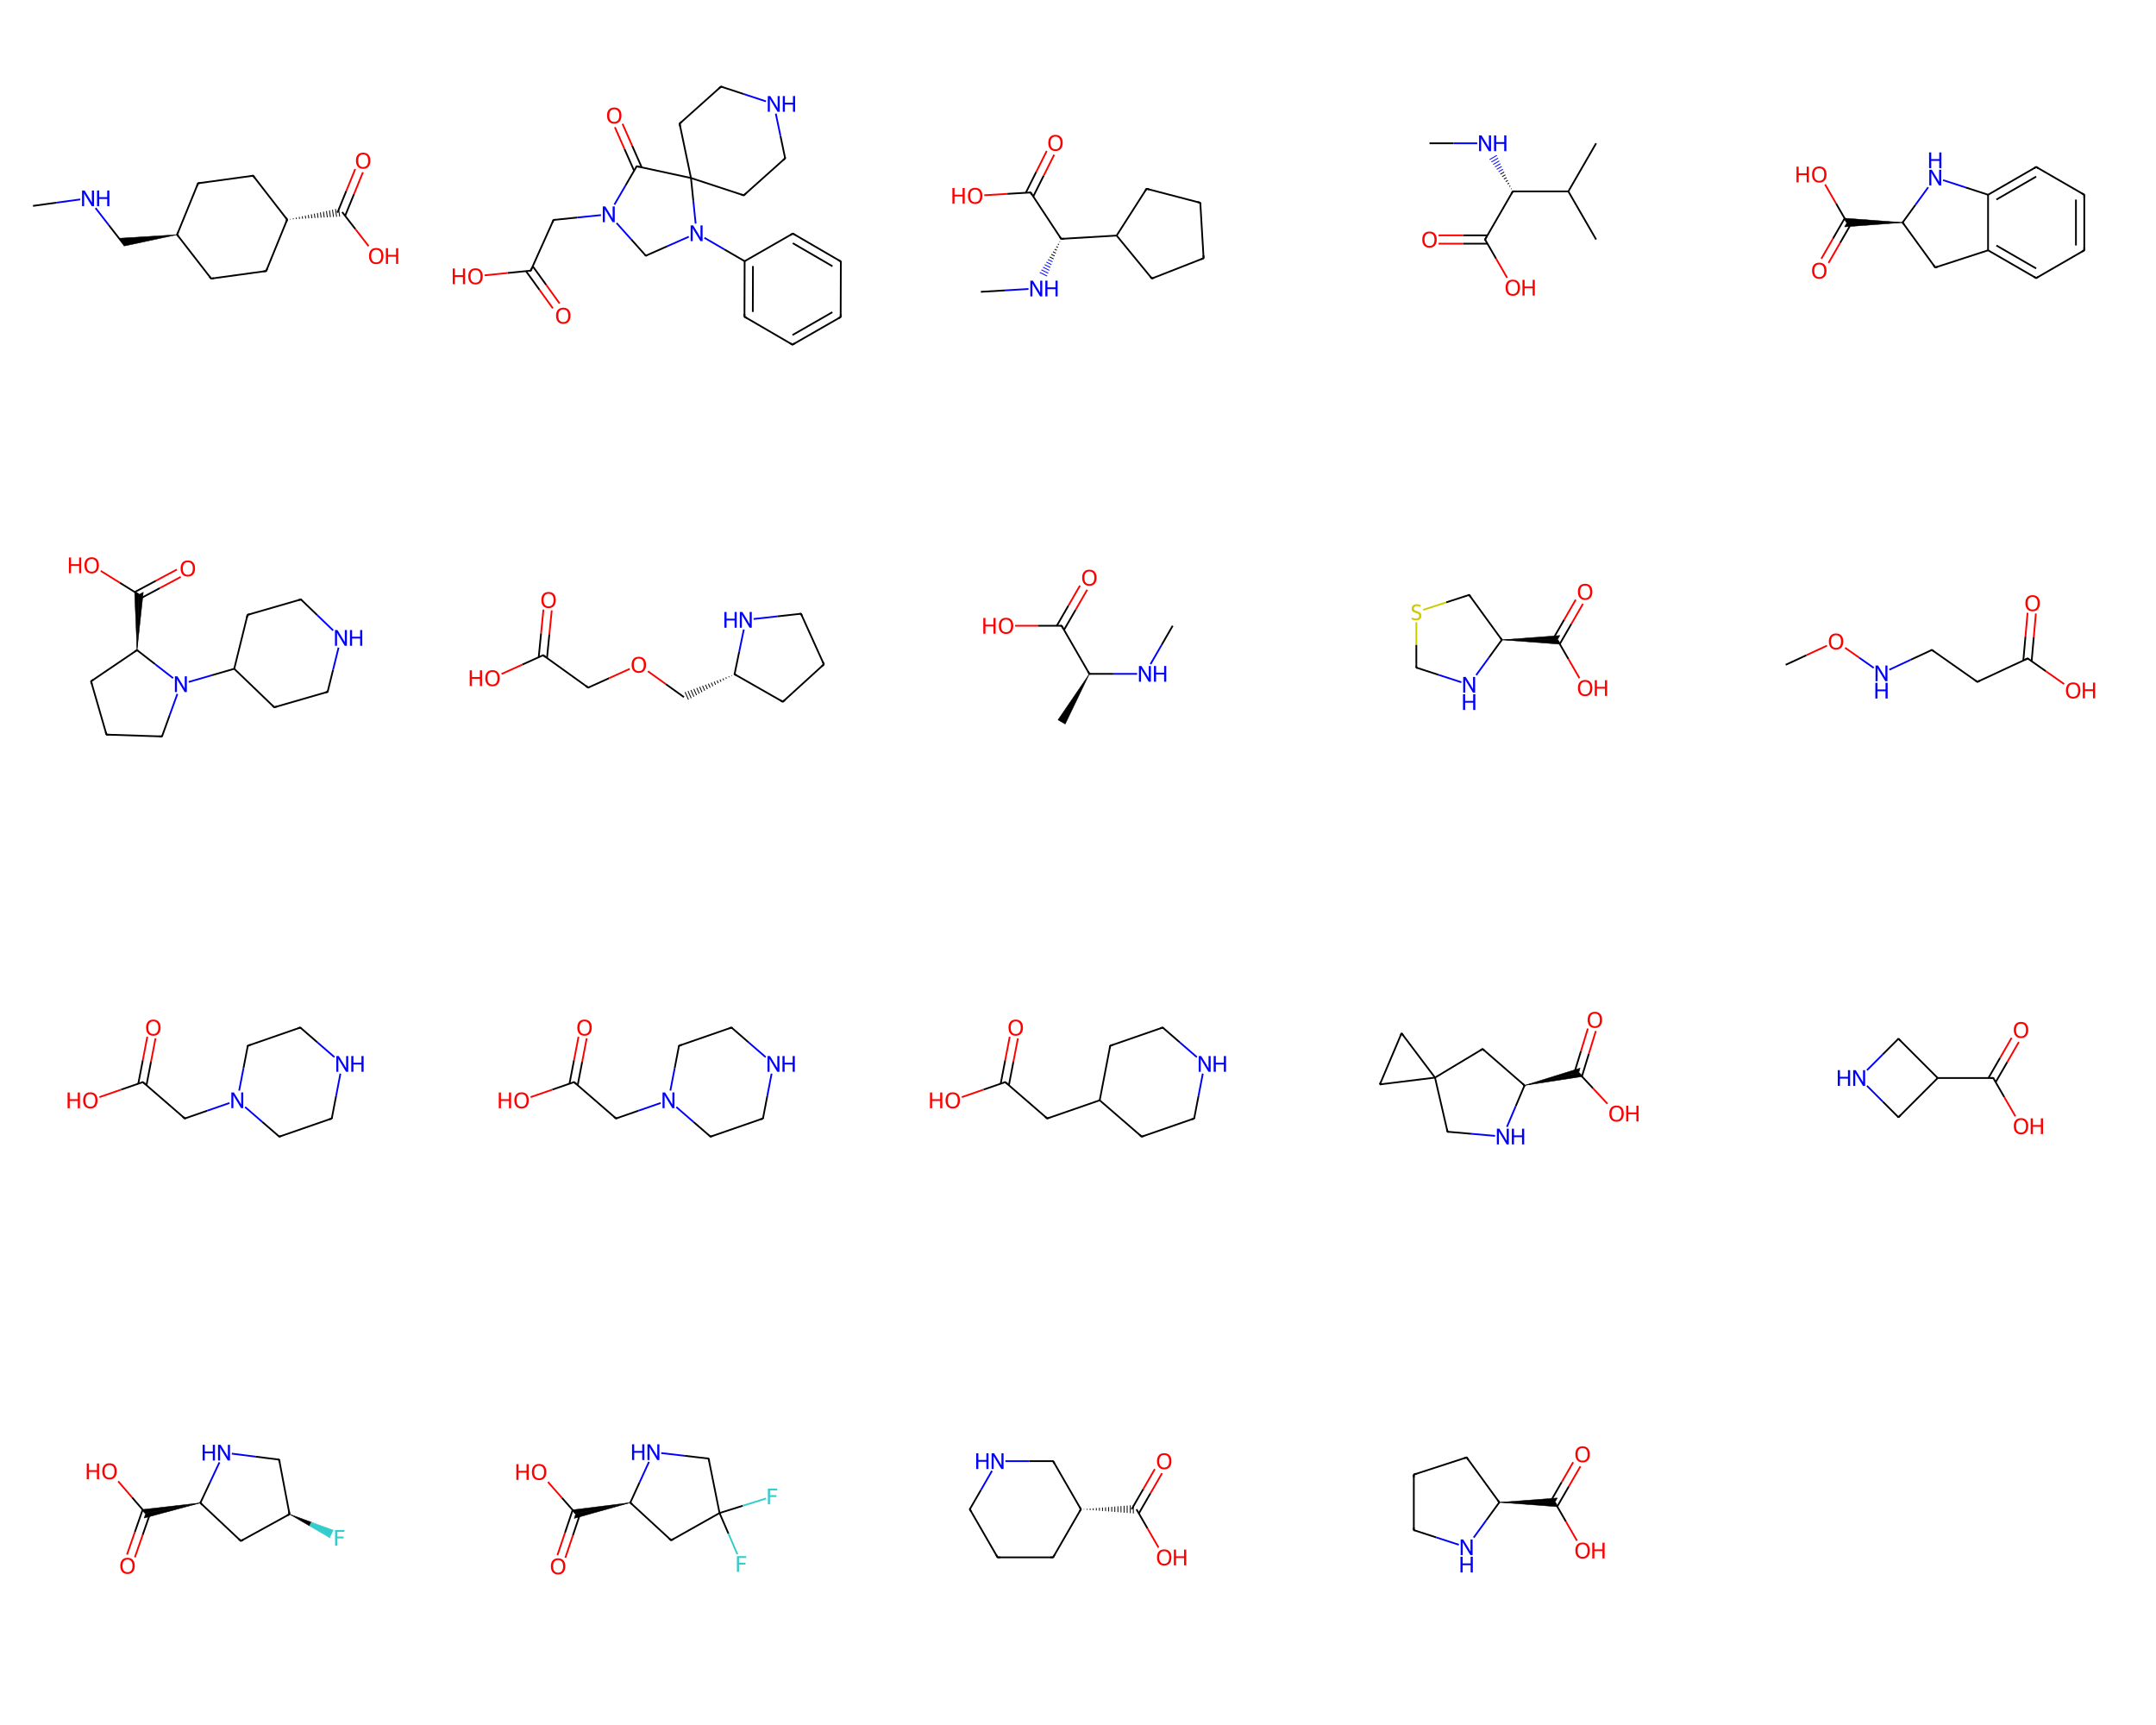

In [90]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in no_primary_amines],molsPerRow=5, subImgSize=(500, 500),maxMols=70)

In [19]:
# Write these amino acids with terminal primary amines to a new file
with open('./Data/M_pro/primary_amines_aa.smi', 'w') as w:
	for mol in primary_amines:
		w.write(f"{mol}")

### Amino Acid Coupling
We are defining the reaction to couple two amino acids here. Note that the primary amines are one set of reactants and the other is the list of all amines (primary and secondary) since amino acids can be coupled together.

In [36]:
rxn  = AllChem.ReactionFromSmarts("[#6:1](=O)[OH].[#7X3;!H0:2]>>[#7:2][#6:1]=[O]")

In [95]:
coupled_aa_prods = []
for primary_amine_bb in primary_amines:
	primary_amine_bb = Chem.MolFromSmiles(primary_amine_bb)
	for amine_bb in no_primary_amines:
		amine_bb = Chem.MolFromSmiles(amine_bb)
		prod_coupled_bb = rxn.RunReactants((primary_amine_bb, amine_bb))[0][0]
		coupled_aa_prods.append(Chem.MolToSmiles(prod_coupled_bb))

In [103]:
# Check whether the products contain a primary amine
# If each molecule has a primary amine then the list for not selected molecules should be empty
coupled_aa_sel, coupled_aa_not_sel = check_substructure(coupled_aa_prods,"[#7X3;H2]")

In [21]:
# Curate Dataset of primary amino acids and other amino acids
primary_aa = []
with open('./Data/M_pro/primary_amines_aa.smi') as f1:
	for mol1 in f1:
		primary_aa.append(Chem.MolFromSmiles(mol1))
aa = []
with open('./Data/M_pro/amino_acids.smi') as f2:
	for mol2 in f2:
		aa.append(Chem.MolFromSmiles(mol2))

In [40]:
prod_test_coupled_aa = rxn.RunReactants((primary_aa[4], aa[4]))[0][0]

In [41]:
Chem.MolToSmiles(prod_test_coupled_aa)

'NC1(C(=O)N2CCC3(CC2)C(=O)N(CC(=O)O)CN3c2ccccc2)CCN(Cc2ccccc2)CC1'

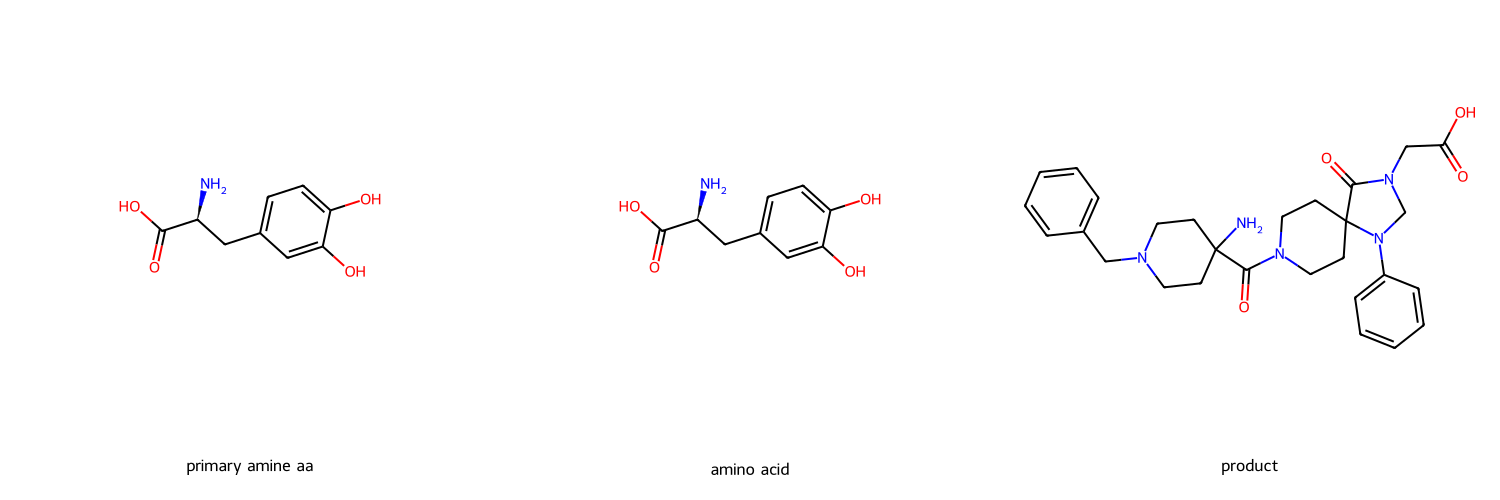

In [86]:
Chem.Draw.MolsToGridImage([primary_aa[0], aa[0], prod_test_coupled_aa],molsPerRow=3, subImgSize=(500, 500), legends=["primary amine aa", "amino acid", "product"])

In [44]:
# Generate a set of coupled amino acids and write them to SMILES
coupled_aa = []
for primary_amine_aa in primary_aa:
	for amino_acid in aa:
		rxn_prod = rxn.RunReactants((amino_acid,primary_amine_aa))[0][0]
		coupled_aa.append(Chem.MolToSmiles(rxn_prod))

In [106]:
# Write the SMILES from the coupled amino acids to a text file 
with open('./Data/M_pro/Input_files/coupled_aa.smi', 'w') as w:
	for number,mol in enumerate(coupled_aa_prods[0:100]):
		reagent_no = 100+number
		w.write(f"{mol}")
		w.write(" ")
		w.write('%d' % reagent_no) # Name of the building block
		w.write(os.linesep)

## Reductive Amination with Aldehyde

### Preparing Aldehyde and Carboxylic acid data
These files will need to be reformatted with names for each of the building blocks.

In [65]:
# First read the files provided
# aldehyde building blocks
aldehydes = []
with open('./Data/M_pro/aldehydes.smi') as f1:
	for mol in f1:
		aldehydes.append(mol.rstrip('\n'))

In [66]:
# Read carboxylic acid building blocks
acids = []
with open('./Data/M_pro/carboxylic_acids.smi') as f2:
	for mol in f2:
		acids.append(mol.rstrip('\n'))

In [107]:
# Write them into new input files that contain names
with open('./Data/M_pro/Input_files/aldehydes_input.smi','w') as w2:
	for number, mol in enumerate(aldehydes[0:100]):
		reagent_no = 200+number
		w2.write(f"{mol}")
		w2.write(" ")
		w2.write('%d' % reagent_no)
		w2.write(os.linesep)

In [108]:
with open('./Data/M_pro/Input_files/acids_input.smi','w') as w4:
	for number, mol in enumerate(acids[0:100]):
		reagent_no = 300+number
		w4.write(f"{mol}")
		w4.write(" ")
		w4.write('%d' % reagent_no)
		w4.write(os.linesep)

### Test Product generation
Let's test this reaction SMARTS pattern to check whether we are getting the correct products.

In [50]:
rxn2 = AllChem.ReactionFromSmarts('[#7X3;H2:1].[#6:2](=O).[#6:3](=O)[O]>>[#6:2][#7:1][#6:3]')

In [51]:
# Generate a test Molecule
aldehyde = Chem.MolFromSmiles(aldehydes[0])
acid = Chem.MolFromSmiles(acids[0])
aa_coupled = Chem.MolFromSmiles(coupled_aa[0])
prod_3mer = rxn2.RunReactants((aa_coupled, aldehyde, acid))[0][0]

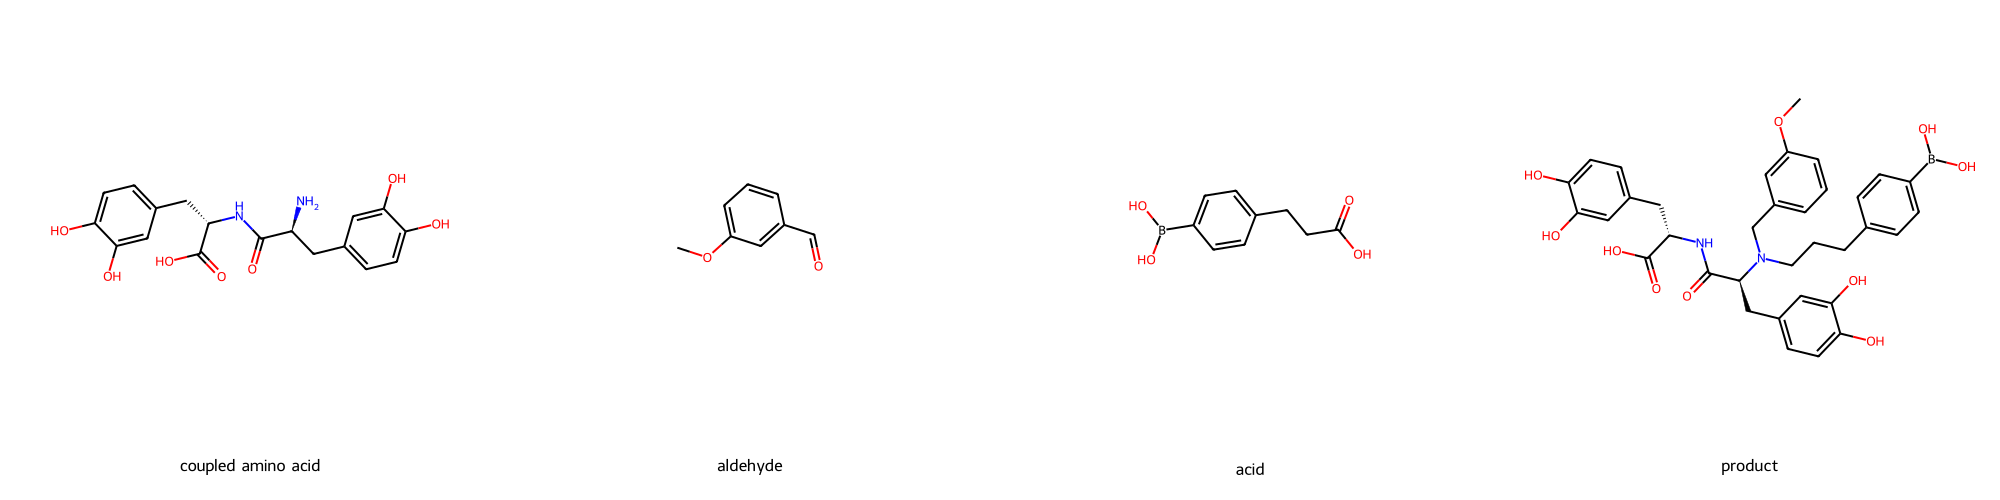

In [52]:
Chem.Draw.MolsToGridImage([aa_coupled, aldehyde, acid, prod_3mer],molsPerRow=4, subImgSize=(500, 500), legends=["coupled amino acid", "aldehyde", "acid", "product"])

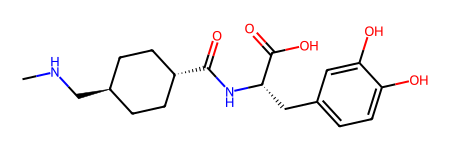

In [85]:
Chem.MolFromSmiles(coupled_aa[1])

# Adenosine A2B inhibitor Library
Utilizes Biginelli multi component reaction to form products.

In [201]:
# Load Data of Interest
aldehydes=[]
with open('./Data/adenosine_A2B/aldehydes.smi') as w:
	for line in w:
		aldehydes.append(line.rstrip('\n'))
		
di_oxo=[]
with open('./Data/adenosine_A2B/dioxo.smi') as o:
	for line in o:
		di_oxo.append(line.rstrip('\n'))

di_nucleo=[]
with open('./Data/adenosine_A2B/dinucleophiles.smi','r') as n:
	for line in n:
		di_nucleo.append(line.rstrip('\n'))

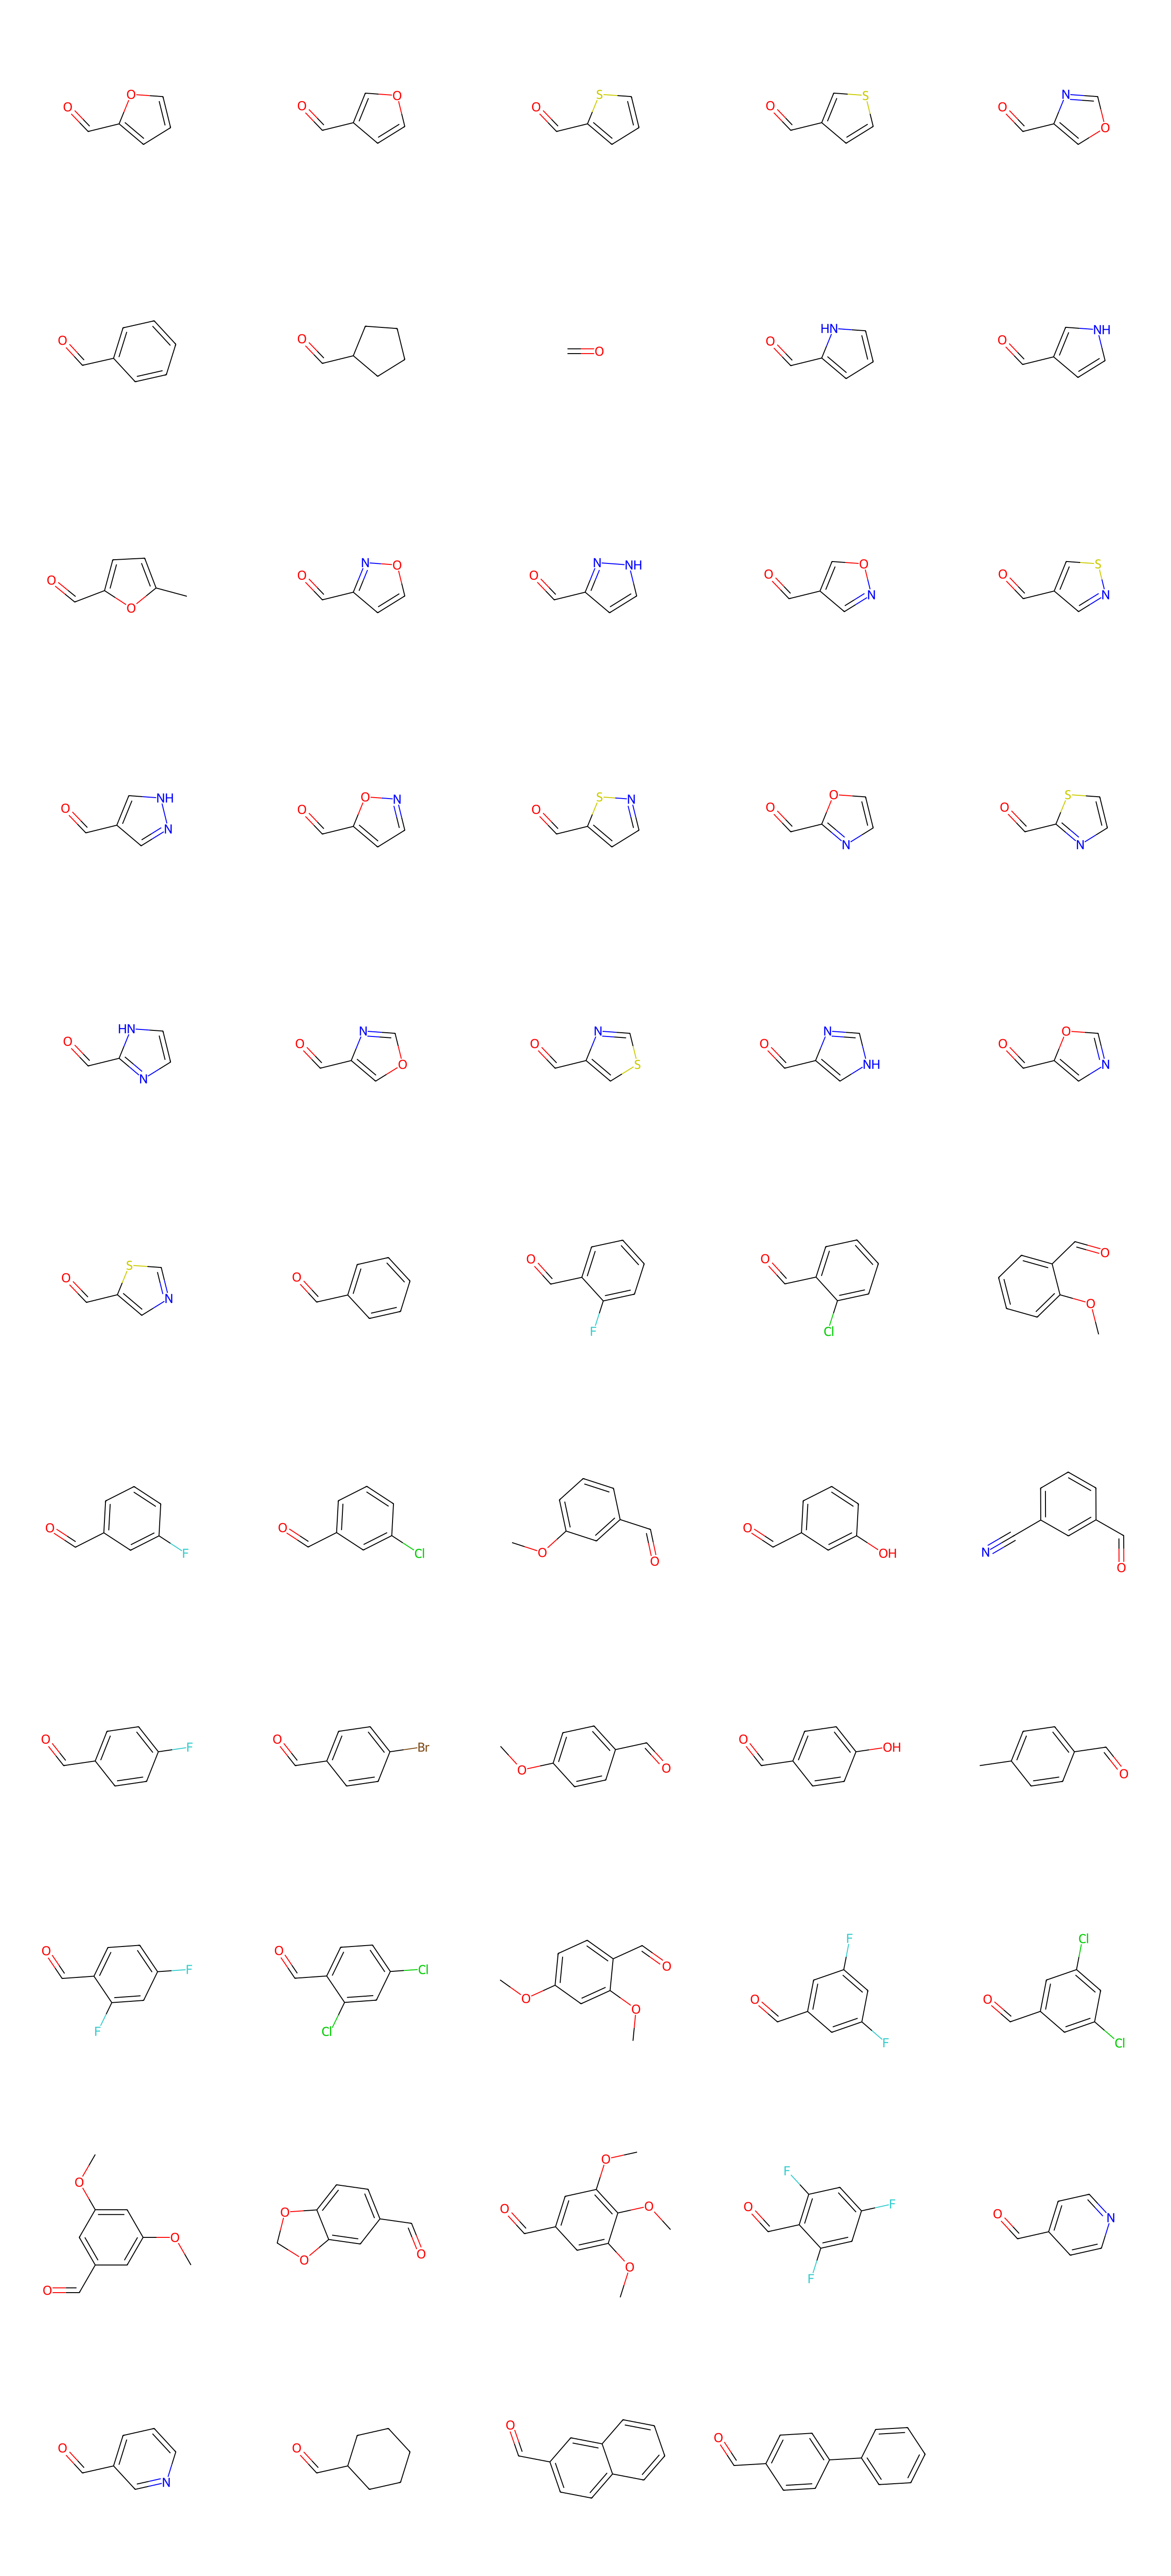

In [227]:
# The Di nucleo building blocks are problematic, so I want to view all of them for reference
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in sel_aldehyde],molsPerRow=5, subImgSize=(500, 500),maxMols=70)

In [222]:
# Let's check how many Building blocks contain the substructures of interest
sel_aldehyde, not_sel_aldehyde = check_substructure(aldehydes,'[C:1](=[O])')
sel_di_oxo, not_sel_di_oxo = check_substructure(di_oxo,'[#6][#6](=[#8])[#6][#6:2](=[#8])[*:3]') # Original- [#6][#6](=[#8])[#6:2][#6](=[#8])[#6,#7,#8,#16]
# [#7][#6:3](~[#7,#8])[#7,#16]
sel_di_nucleo, not_sel_di_nucleo = check_substructure(di_nucleo,'[#7X2:6]~[#6X3:7](~[#7:8])~[#7X3H2:9]')
print('Total No. of Products: %d' % (len(sel_di_oxo)*len(sel_aldehyde)*len(sel_di_nucleo)))

Total No. of Products: 32292


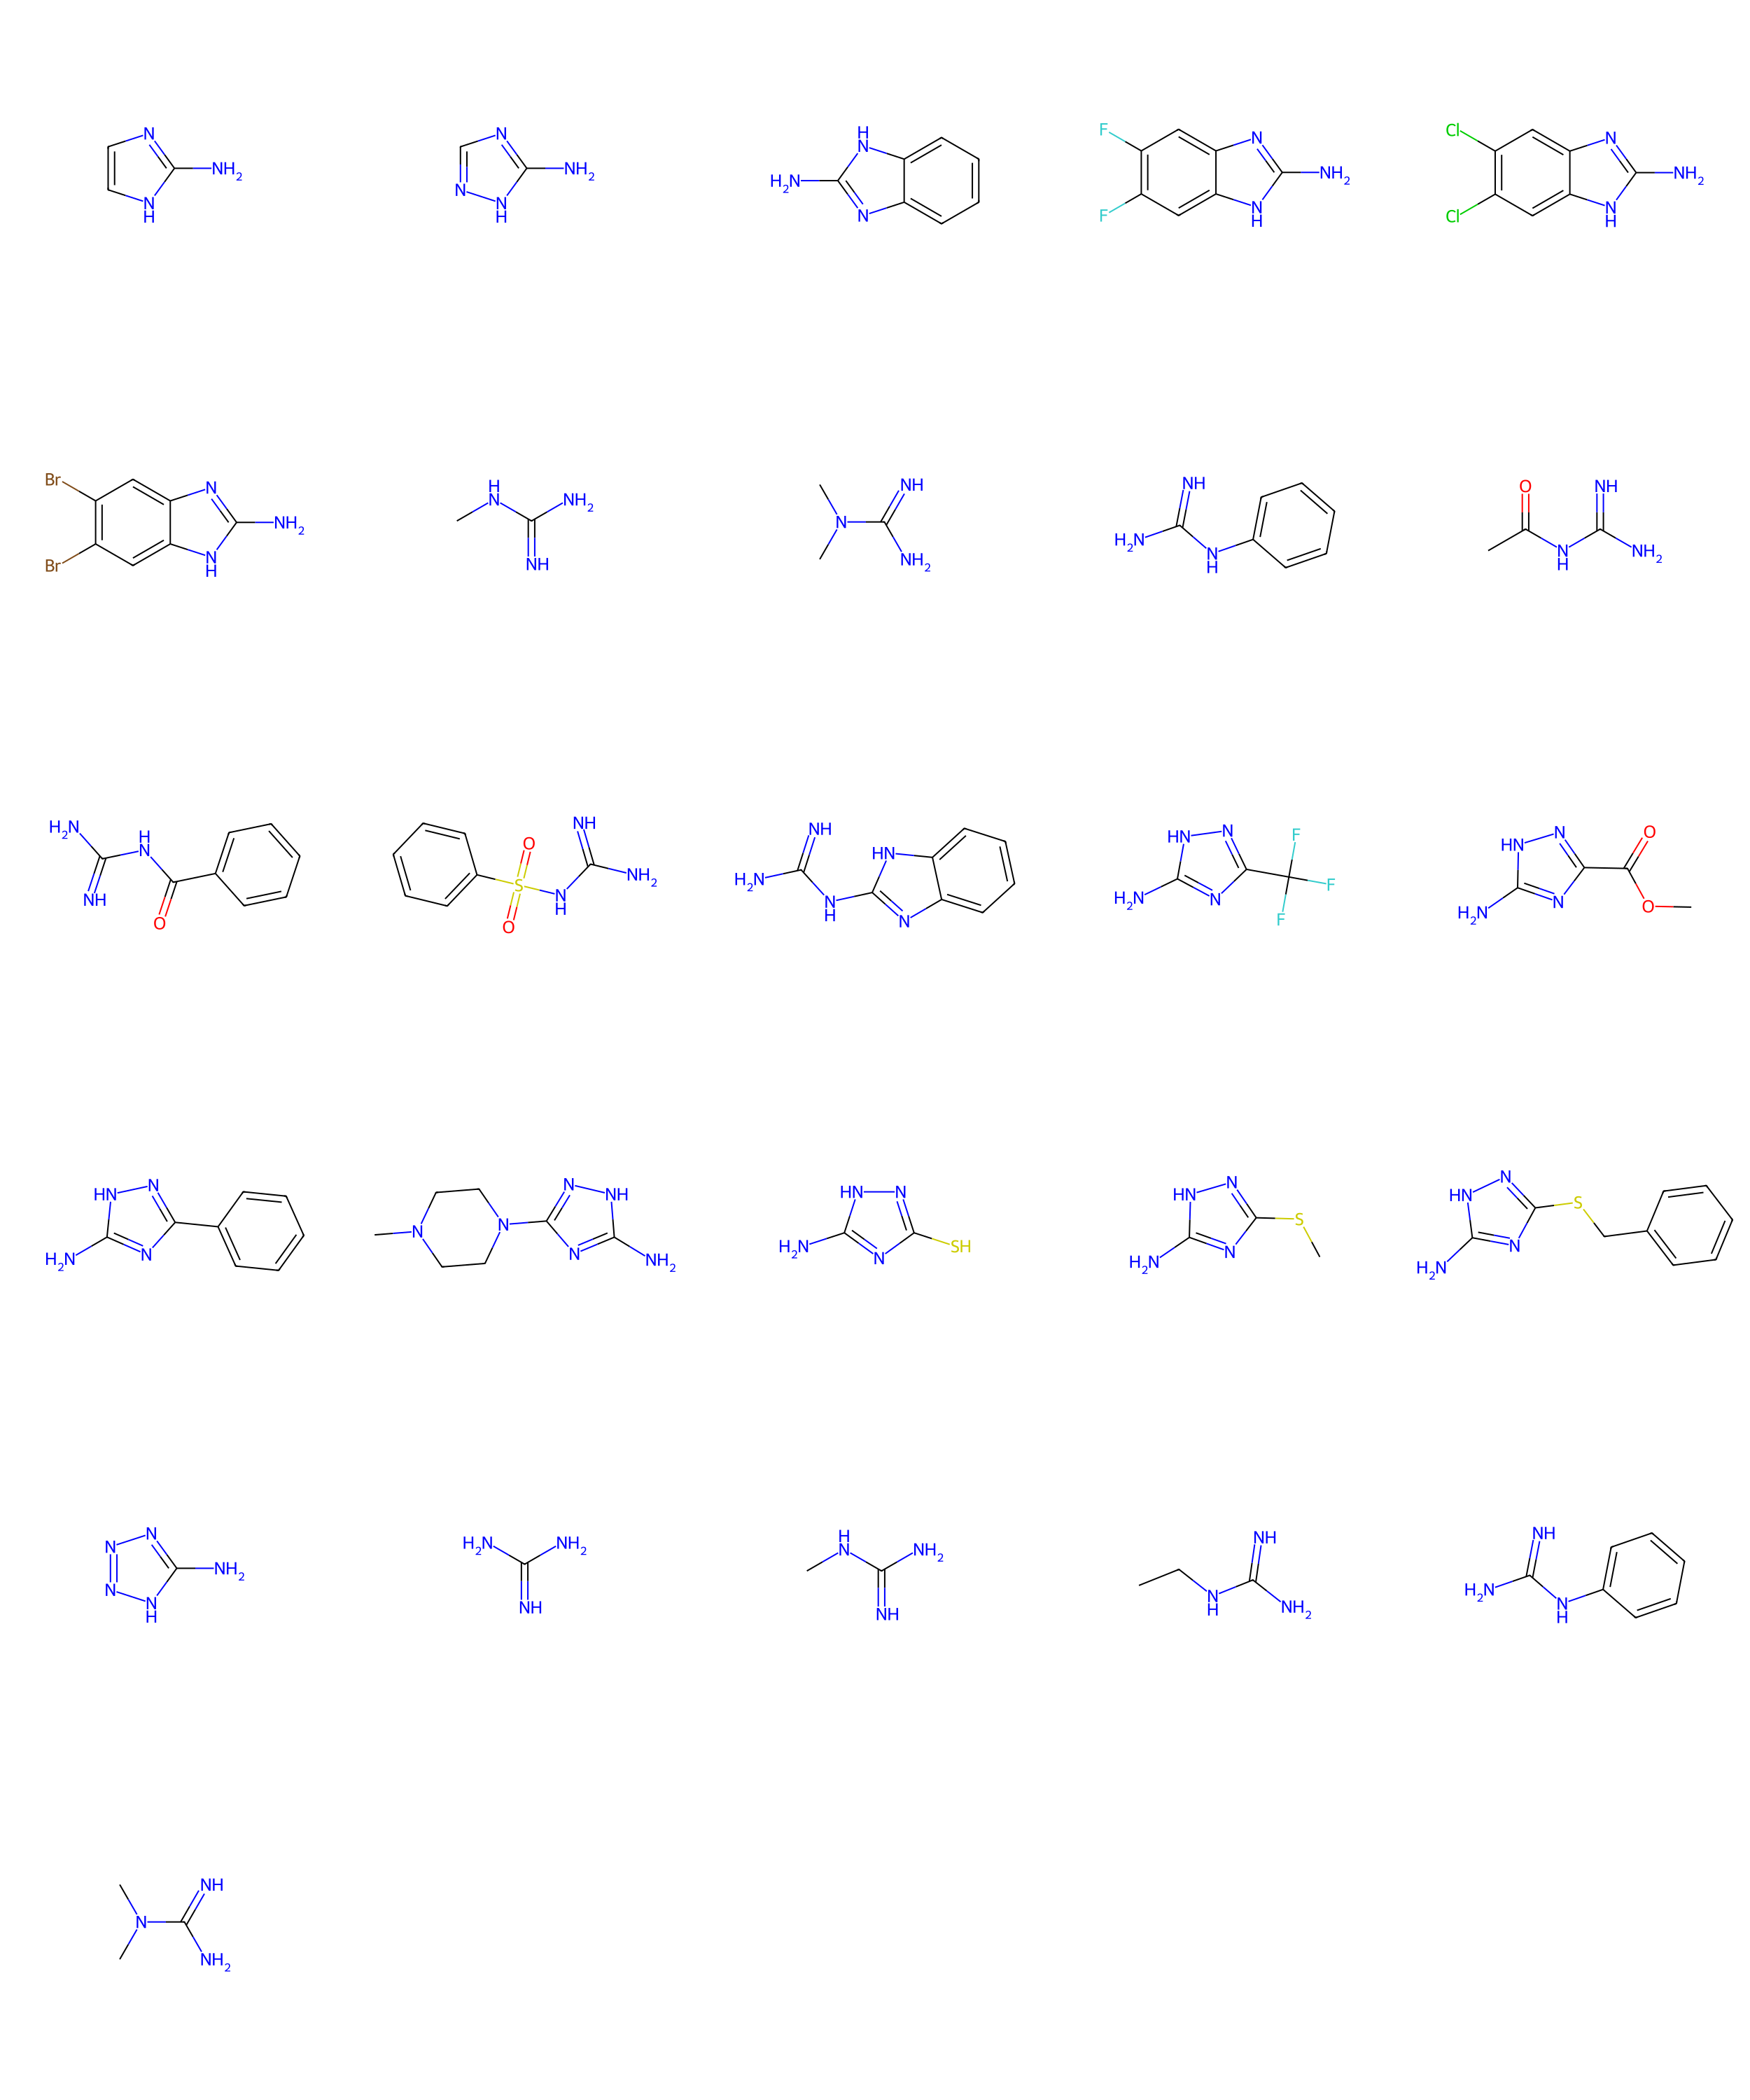

In [223]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in sel_di_nucleo],molsPerRow=5, subImgSize=(500, 500),maxMols=70)

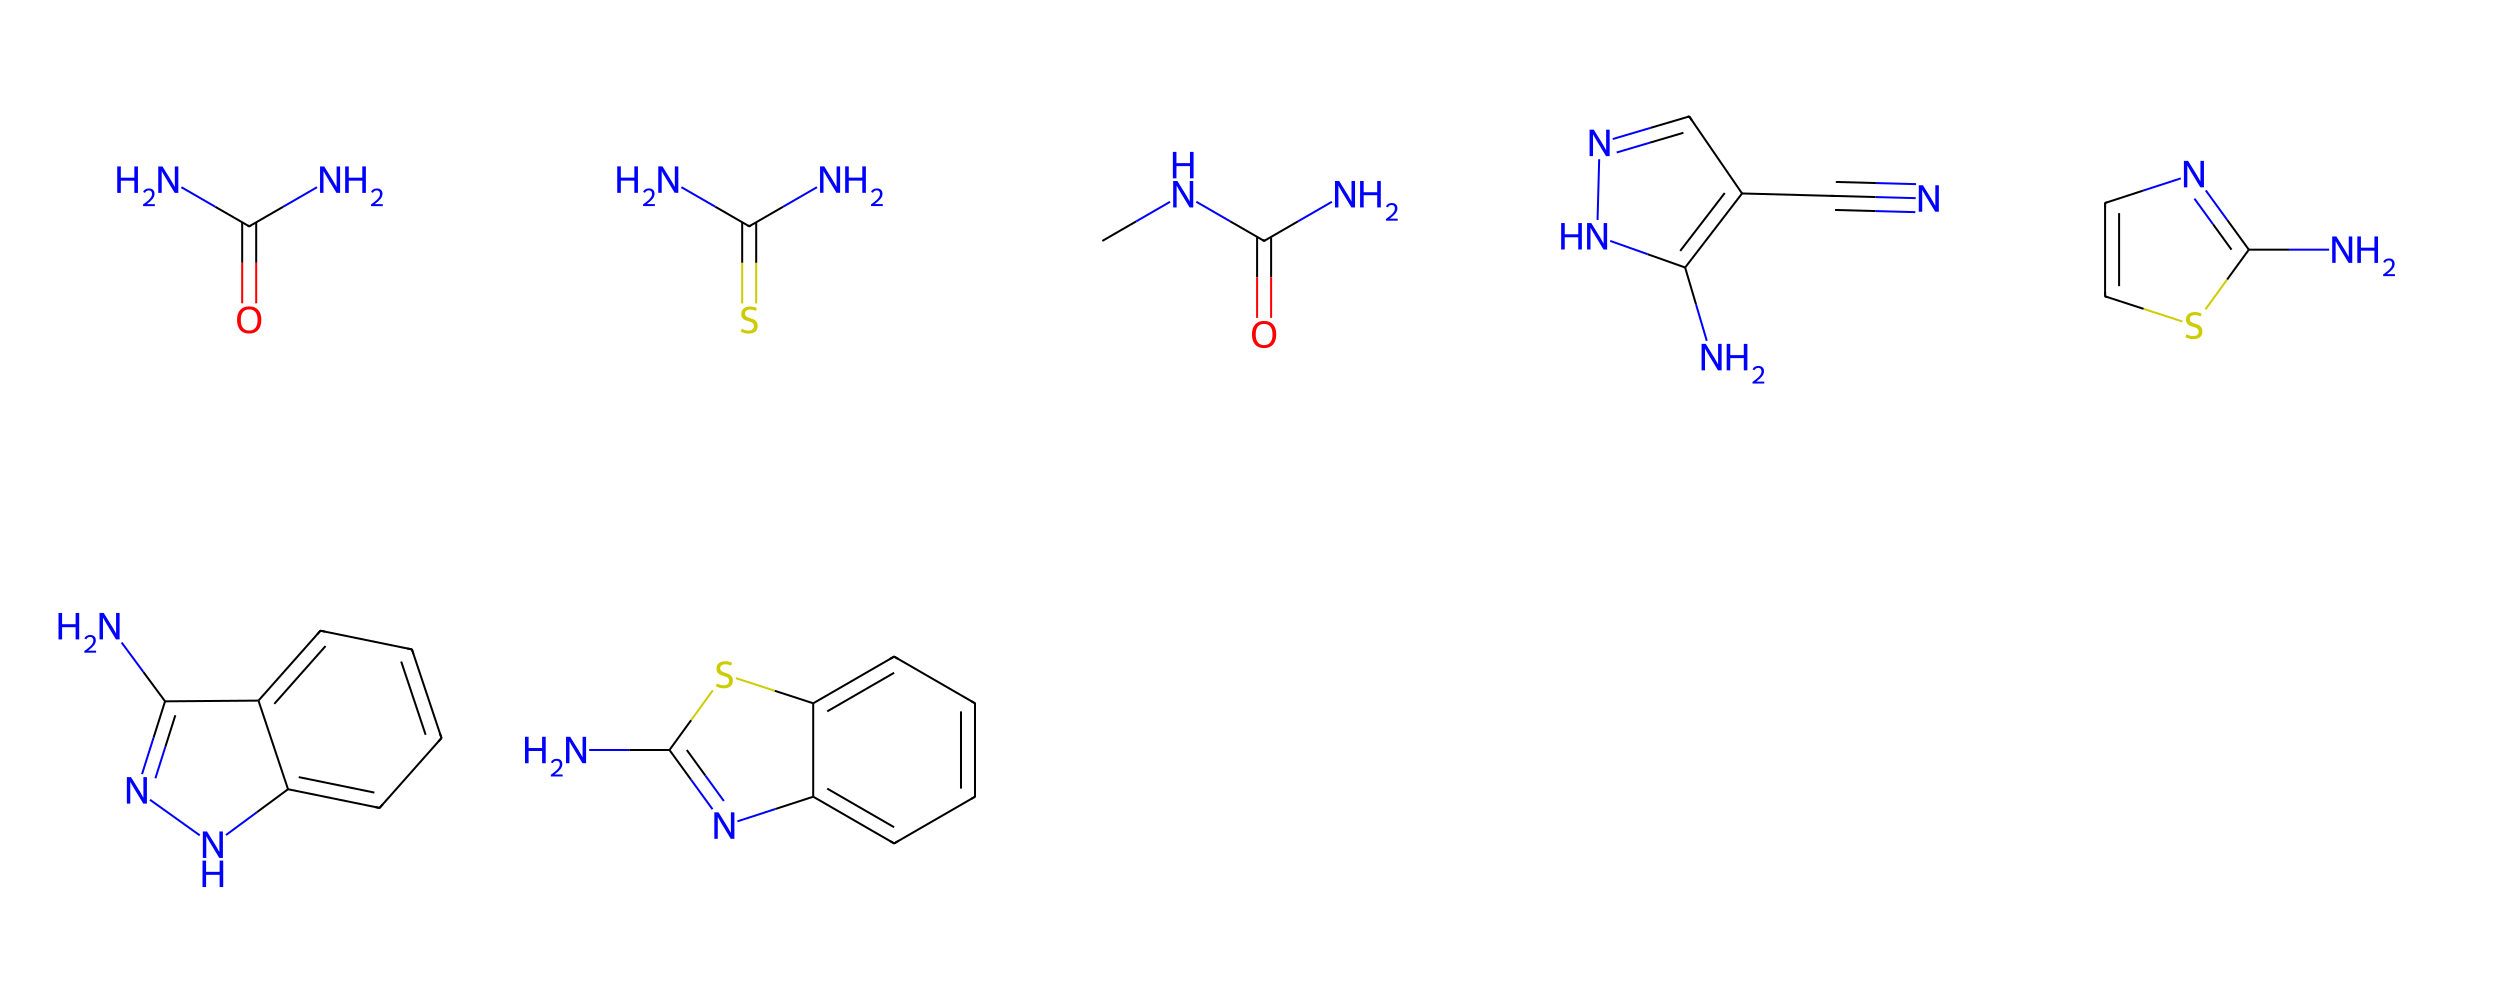

In [224]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in not_sel_di_nucleo],molsPerRow=5, subImgSize=(500, 500),maxMols=70)

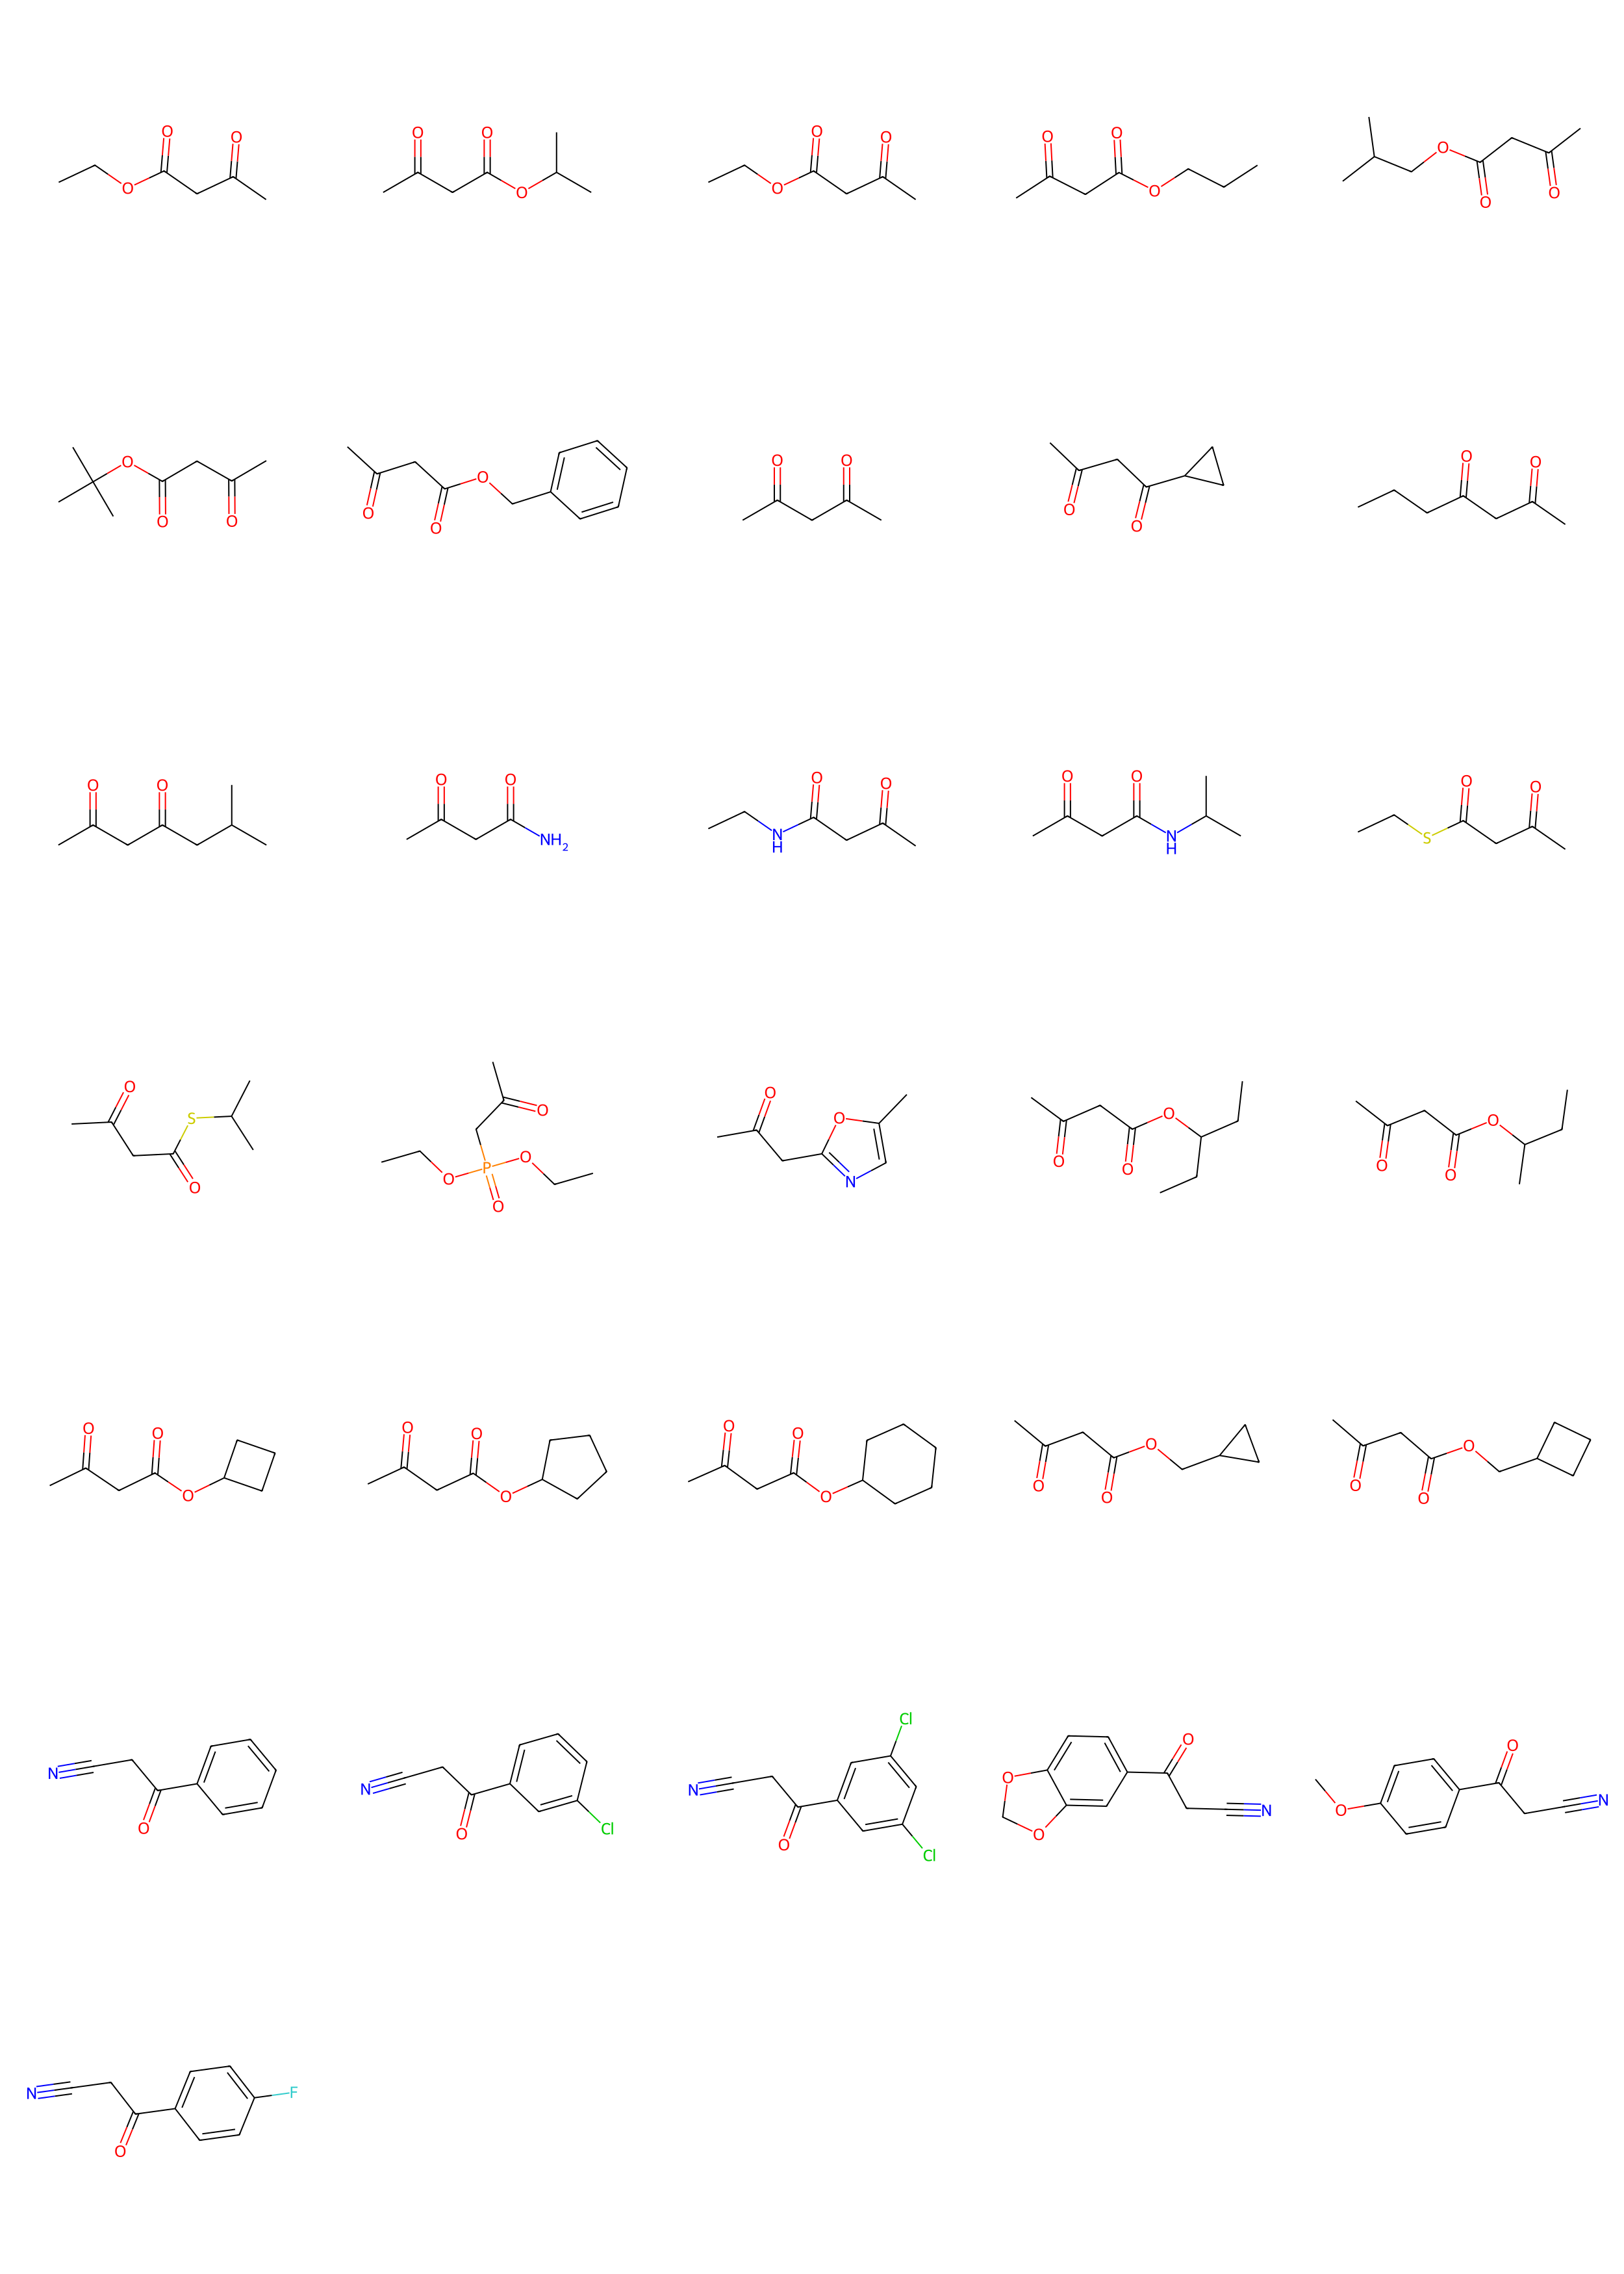

In [182]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in sel_di_oxo],molsPerRow=5, subImgSize=(500, 500),maxMols=70)

## Biginelli Reaction for Adenosine A2B

In [215]:
biginelli_rxn = AllChem.ReactionFromSmarts("[#6:1](=[O]).[#6][#6](=[#8])[#6][#6:2](=[#8])[*:3].[#7X2:6]~[#6X3:7](~[#7:8])~[#7X3H2:9]>>[#6:1]1[#6]([#6:2](=[#8])[*:3])=[#6]([#6])[#7:9]~[#6X3:7](~[#7X3H0:8])~[#7:6]1")

In [ ]:
# Original SMARTS - [#6:1](=[O]).[#6][#6](=[#8])[#6][#6:2](=[#8])[*:3].[#7X2:6]~[#6X3:7](~[#7:8])~[#7X3H2:9]>>[#6:1]1[#6]([#6:2](=[#8])[*:3])=[#6]([#6])[#6][#7:9]~[#6X3;H1:7](~[#7X3H0:8])~[#7:6]1

In [ ]:
#[C:1](=[O]).[#6][#6](=[#8])[#6:2][#6:3](=[#8:4])[#6,#7,#8,#16:5].[#7X2:6]~[#6X3:7]-[#7X3H2:8]>>[C]C1=[#6:2]([#6:3](=[#8:4])[#6,#7,#8,#16:5]

# [C:1](=[O]).[#6][#6](=[#8])[#6:2][#6:3](=[#8])[#6,#7,#8,#16].[#7X2:6]~[#6X3:7](~[#7:8])~[#7X3H2:9]>>C1=[#6:2]([#6:3])[#6:1][N:6]~[#6X3;H1:7](~[#7X3H0:8])~[N:9]1

In [ ]:
#6X3;H1:7
# [#7X2:6]~[#6X3:7]-[#7X3H2:8]
# [#7X2:6]~[#6X3:7](~[#7:8])~[#7X3H2:9]
# [n:9][c:6]([n:8])[N:7]

In [241]:
# Let's run a test with the above reaction SMARTS
aldehyde_mol = Chem.MolFromSmiles(sel_aldehyde[0])
di_oxo_mol = Chem.MolFromSmiles(sel_di_oxo[0])
di_nucleo_mol = Chem.MolFromSmiles(sel_di_nucleo[0])
prod_biginelli = biginelli_rxn.RunReactants([aldehyde_mol, di_oxo_mol, di_nucleo_mol])[0][0]

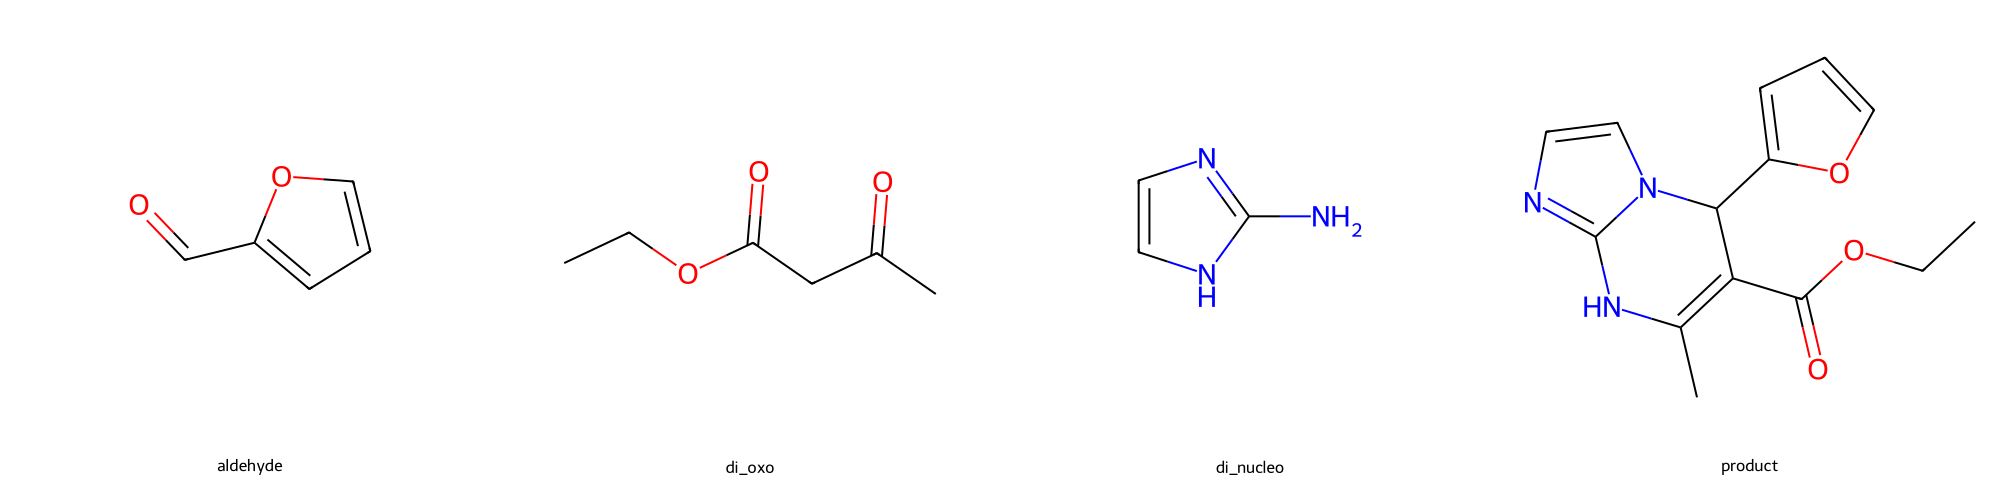

In [235]:
Chem.Draw.MolsToGridImage([aldehyde_mol, di_oxo_mol, di_nucleo_mol, prod_biginelli],molsPerRow=4, subImgSize=(500, 500), legends=["aldehyde", "di_oxo", "di_nucleo", "product"])

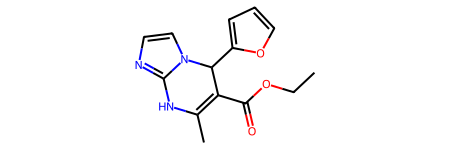

In [243]:
prod_biginelli

In [237]:
Chem.SanitizeMol(prod_biginelli)

rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

The sanitization seems to be working fine. This is good. I have tested the products being formed with aliphatic di-nucleophile reactants as well.

In [245]:
prod_biginelli_h = Chem.AddHs(prod_biginelli)

In [246]:
true_prod_biginelli = Chem.MolFromSmiles('O=C(OCC)C3=C(C)NC4=NN=NN4C3C5=CC=CO5')
true_prod_biginelli_h = Chem.AddHs(true_prod_biginelli)

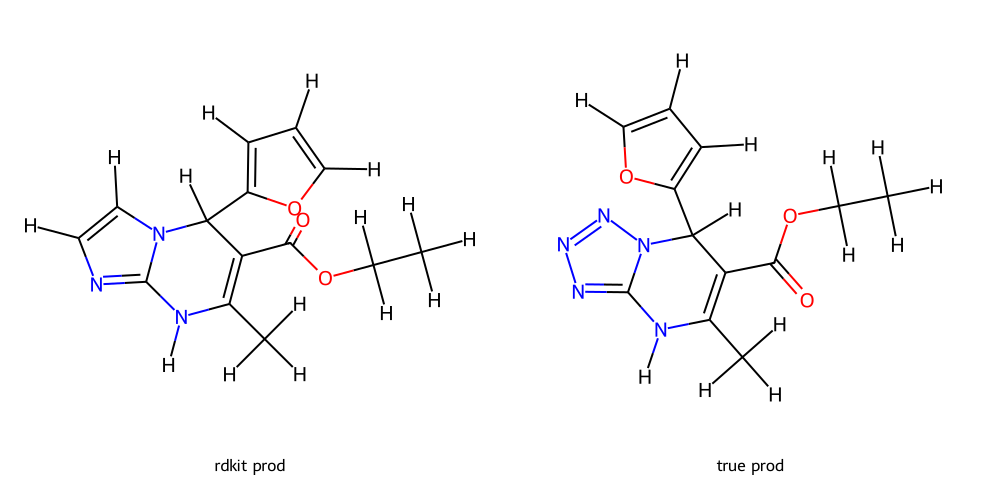

In [247]:
Chem.Draw.MolsToGridImage([prod_biginelli_h,true_prod_biginelli_h], molsPerRow=2, subImgSize=(500, 500),legends=["rdkit prod", "true prod"])

In [253]:
# Let's write the Input files for Thompson Sampling
# Write them into new input files that contain names
with open('./Data/adenosine_A2B/Input_files/aldehydes_input.smi', 'w') as w1:
	for number, mol in enumerate(sel_aldehyde):
		reagent_no = 100 + number
		w1.write(f"{mol}")
		w1.write(" ")
		w1.write('%d' % reagent_no)
		w1.write(os.linesep)
with open('./Data/adenosine_A2B/Input_files/di_oxo_input.smi', 'w') as w2:
	for number, mol in enumerate(sel_di_oxo):
		reagent_no = 200 + number
		w2.write(f"{mol}")
		w2.write(" ")
		w2.write('%d' % reagent_no)
		w2.write(os.linesep)
with open('./Data/adenosine_A2B/Input_files/di_nucleo_input.smi', 'w') as w3:
	for number, mol in enumerate(sel_di_nucleo):
		reagent_no = 300 + number
		w3.write(f"{mol}")
		w3.write(" ")
		w3.write('%d' % reagent_no)
		w3.write(os.linesep)